<a href="https://colab.research.google.com/github/stavkran/IMDbReviews-Sentiment-Analysis/blob/main/IMDbReviewsSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
We have to predict the sentiment of the movie reviews from the Internet Movie Database (IMDb) using different classification models.

# Setting up Libraries
Impoting necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import os
import warnings

## Importing the dataset

In [7]:
imdb_data = pd.read_csv('IMDBDataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


## Data describe and Sentiment Count

In [8]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [9]:
#sentiment count
imdb_data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

We can see that the dataset is balanced.

# Splitting the Training dataset

In [10]:
#split the dataset
#train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]
#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


## Text Processing
Cleaning, pre-processing, and normalising text to bring text components like phrases and words to some standard format is one of the key steps before going into the process of feature engineering and modelling.

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer

# Download the stopwords dataset if you haven't already
nltk.download('stopwords')

# Tokenization of text
tokenizer = ToktokTokenizer()

# Setting English stopwords
stopword_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Removing html strips and noise text
Here in data head we can see some html code so first we need to clean that html strips. Also removing some noisy texts along with square brackets.

In [14]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

<ipython-input-14-bd08e05e708b>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


### Removing special characters
We need to make sure that any special characters are deleted

In [15]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

### Text Stemming
Stemming is a technique for eliminating affixes from words in order to retrieve the base form. It’s the same as pruning a tree’s branches down to the trunk. The stem of the terms eating, eats, and eaten, for example, is eat.

In [16]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

### Removing stopwords
Stop words are words that have little or no meaning, especially when synthesising meaningful aspects from the text.

Stop words are words that are filtered out of natural language data (text) before or after it is processed in computers. While “stop words” usually refers to a language’s most common terms, all-natural language processing algorithms don’t employ a single universal list.

Stopwords include words such as a, an, the, and others.

In [17]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{'and', 'now', 'too', "weren't", "mightn't", 'very', 'whom', 'you', 'against', 'can', 'don', 'it', 'yours', 'of', 'any', 'if', 'this', 'into', 'who', 't', 'its', 've', 'y', "she's", "you've", 'yourselves', 'had', 'our', 'hers', 'but', "doesn't", 'how', "that'll", 'are', 'doing', 'ain', "needn't", 'off', 'hadn', 'your', 'in', 'few', 'was', 'through', 'they', "don't", 'does', 'at', "shan't", 'having', 'all', 'herself', 'other', 'isn', 'o', 'have', 'll', 'just', 'up', 'has', 'a', 'themselves', 'wasn', 'hasn', 'doesn', 'itself', 'mustn', "hadn't", "you'll", "isn't", 'ours', 'is', 'himself', 'that', 'between', 'their', 'where', 'about', 'out', "didn't", 'shan', 'should', 'over', 'being', 'shouldn', 'no', "you'd", 'why', "haven't", 'again', 'to', 'nor', "couldn't", 'haven', 'me', 'ma', 'until', 'd', 'or', 'more', 'wouldn', 'during', 'them', 'same', 'some', 'were', "shouldn't", 'there', 'here', 'aren', 'ourselves', 'these', 'once', 'be', 'her', "should've", 'down', 'below', 'as', "hasn't", 'm

### Normalisation
Text normalisation is the process of converting previously uncanonical text into a single canonical form. Because input is guaranteed to be consistent before operations are done on it, normalising text before storing or processing it allows for separation of concerns.

In [18]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]

'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

In [19]:
#Normalized test reviews
norm_test_reviews=imdb_data.review[40000:]
norm_test_reviews[45005]

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

### Bags of words model
It is used to convert text documents to numerical vectors or bag of words.
The Bag of Words (BoW) model is the most basic type of numerical text representation. A phrase can be represented as a bag of words vector, just like the term itself (a string of numbers).

In [20]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6209089)
BOW_cv_test: (10000, 6209089)


### Term Frequency-Inverse Document Frequency model (TFIDF)
It is used to convert text documents to matrix of tfidf features.

The term frequency-inverse document frequency statistic is a numerical measure of how essential a word is to a document in a collection.

In [21]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)

#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)

print('Tfidf_train:',tv_train_reviews.shape)

print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6209089)
Tfidf_test: (10000, 6209089)


### Labeling the sentiment text
Label Binarizer is a SciKit Learn class that takes Categorical data and outputs a Numpy array. Unlike Label Encoder, it encodes data into dummy variables that indicate whether a specific label is present or not. Label Binarizer is used to encode column data.

In [23]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

(50000, 1)
[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


### Modeling the dataset
We'll build Multinomial Naive Bayes model for both bag of words and tfidf features

The Multinomial Nave Bayes algorithm considers a feature vector in which each term reflects the number of times it appears or how frequently it appears, i.e. frequency.

In [24]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


In [25]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


### Accuracy of the model
Accuracy for both the approach both bag of words and tfidf features

In [26]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.751
mnb_tfidf_score : 0.7509


### Visualizing the classification report

In [27]:
#Classification report for bag of words
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



### Confusion matrix
A confusion matrix is a table that shows how well a classification model (or “classifier”) performs on a set of test data for which the true values are known. The confusion matrix itself is straightforward, but the associated nomenclature might be perplexing.

In [28]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3736 1271]
 [1219 3774]]
[[3729 1278]
 [1213 3780]]


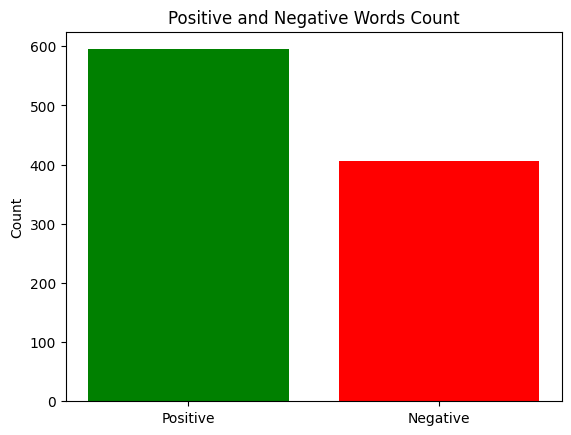

In [31]:
positive_text=norm_train_reviews[1]
negative_text=norm_train_reviews[8]

# Count of positive and negative words
positive_count = len(positive_text)
negative_count = len(negative_text)

# Data for the bar chart
categories = ['Positive', 'Negative']
counts = [positive_count, negative_count]

# Create the bar chart
plt.bar(categories, counts, color=['green', 'red'])
plt.title('Positive and Negative Words Count')
plt.ylabel('Count')
plt.show()

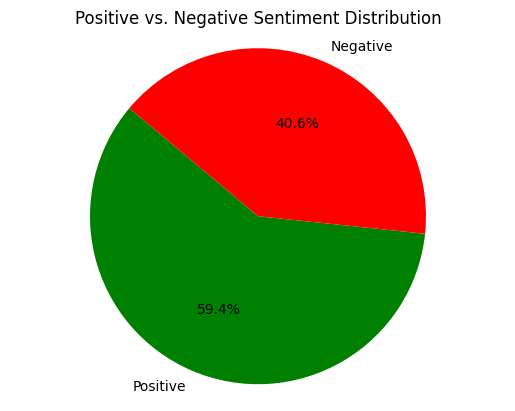

In [34]:
labels = ['Positive', 'Negative']
sizes = [positive_count, negative_count]
colors = ['green', 'red']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Positive vs. Negative Sentiment Distribution')
plt.show()

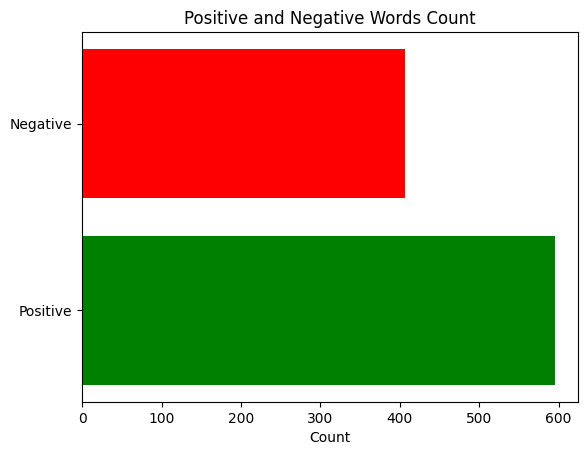

In [35]:
categories = ['Positive', 'Negative']
counts = [positive_count, negative_count]

plt.barh(categories, counts, color=['green', 'red'])
plt.title('Positive and Negative Words Count')
plt.xlabel('Count')
plt.show()

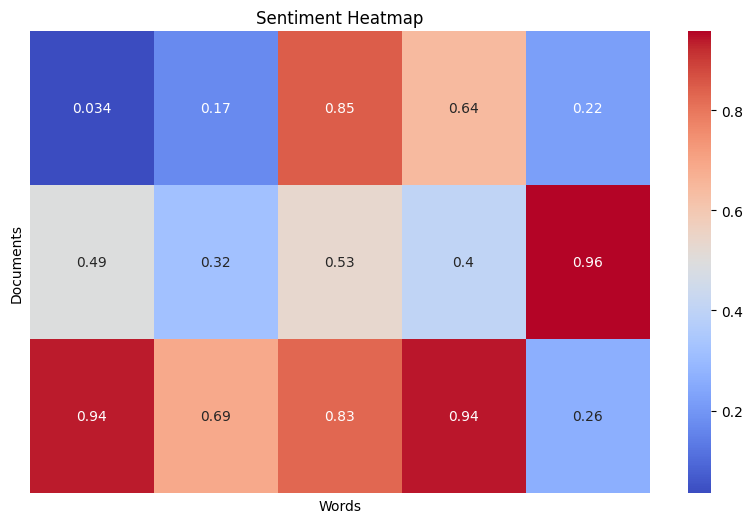

In [38]:
sentiment_scores_matrix = np.random.rand(3, 5)

# Create a heatmap
plt.figure(figsize=(10, 6))  # Set the figure size
sns.heatmap(sentiment_scores_matrix, cmap='coolwarm', annot=True, xticklabels=False, yticklabels=False)

# Set labels and title
plt.xlabel('Words')
plt.ylabel('Documents')
plt.title('Sentiment Heatmap')

# Show the heatmap
plt.show()